In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time
import os
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/LTU (1)/ADL_share/Project/data'

import torchvision.transforms as transforms

transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=path+'/train', transform=transforms)
val_dataset = ImageFolder(root=path+'/val', transform=transforms)
test_dataset = ImageFolder(root=path+'/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
num_classes = 2
batch_size = 8

feature_extract = False

activation = nn.LeakyReLU(0.1)
dropout = nn.Dropout(0.5)

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

classifier_addon = nn.Sequential(
    nn.Linear(2048,1024),
    activation,
    dropout,
    nn.Linear(1024,512),
    activation,
    dropout,
    nn.Linear(512,256),
    activation,
    dropout,
    nn.Linear(256,2)
)

model_ft.classifier[6] = nn.Linear(num_ftrs,2048)
model_ft.classifier.append(classifier_addon)

input_size = 224

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
	 classifier.7.0.weight
	 classifier.7.0.bias
	 classifier.7.3.weight
	 classifier.7.3.bias
	 classifier.7.6.weight
	 classifier.7.6.bias
	 classifier.7.9.weight
	 classifier.7.9.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30

model_ft, hist = train_model(model_ft,
                             dataloaders,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 0.3615 Acc: 0.8417
val Loss: 0.4426 Acc: 0.8241

Epoch 1/29
----------
train Loss: 0.2945 Acc: 0.8904
val Loss: 0.3564 Acc: 0.8241

Epoch 2/29
----------
train Loss: 0.2507 Acc: 0.9033
val Loss: 0.5682 Acc: 0.7361

Epoch 3/29
----------
train Loss: 0.2402 Acc: 0.9003
val Loss: 0.3234 Acc: 0.8426

Epoch 4/29
----------
train Loss: 0.2280 Acc: 0.9189
val Loss: 0.2349 Acc: 0.9213

Epoch 5/29
----------
train Loss: 0.2207 Acc: 0.9201
val Loss: 0.5188 Acc: 0.8889

Epoch 6/29
----------
train Loss: 0.2089 Acc: 0.9199
val Loss: 0.3780 Acc: 0.8843

Epoch 7/29
----------
train Loss: 0.1977 Acc: 0.9294
val Loss: 0.1954 Acc: 0.9120

Epoch 8/29
----------
train Loss: 0.1983 Acc: 0.9270
val Loss: 0.2620 Acc: 0.9306

Epoch 9/29
----------
train Loss: 0.1903 Acc: 0.9278
val Loss: 0.3561 Acc: 0.8935

Epoch 10/29
----------
train Loss: 0.1756 Acc: 0.9368
val Loss: 0.2200 Acc: 0.9167

Epoch 11/29
----------
train Loss: 0.1854 Acc: 0.9344
val Loss: 0.2655 Acc: 0.9167

Ep

In [ ]:
torch.save(model_ft.state_dict(), './alexnet_finetuned2.pth')

In [ ]:
activation = nn.LeakyReLU(0.1)
dropout = nn.Dropout(0.5)

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

classifier_addon = nn.Sequential(
    nn.Linear(2048,1024),
    activation,
    dropout,
    nn.Linear(1024,512),
    activation,
    dropout,
    nn.Linear(512,256),
    activation,
    dropout,
    nn.Linear(256,2)
)

model_ft.classifier[6] = nn.Linear(num_ftrs,2048)
model_ft.classifier.append(classifier_addon)
input_size = 224

model_ft.load_state_dict(torch.load('./alexnet_finetuned2.pth'))

<All keys matched successfully>

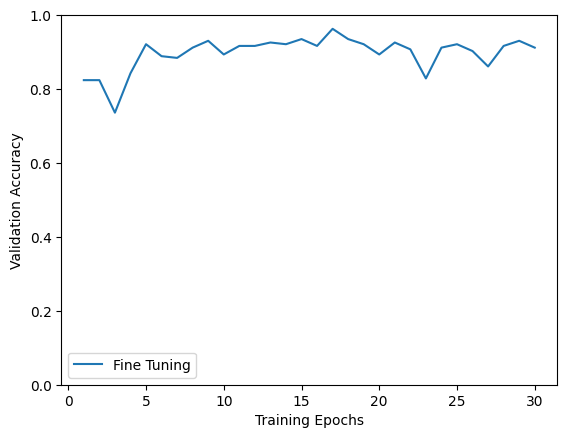

In [ ]:
fhist = []

fhist = [h.cpu().numpy() for h in hist]

plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
#plt.plot(range(1,num_epochs+1),ohist,label="Fine Tuning")
plt.plot(range(1,num_epochs+1),fhist,label="Fine Tuning")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()
plt.show()

In [ ]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct // total} %')

Accuracy on test set: 89 %
